# Experiment 4: Attack Type Generalization (MNIST)

## Experiment Goal
Verify that robustness findings **generalize** across different attack types beyond label flipping.

## Research Questions
1. Does width-based robustness work for different attack types?
2. How do label flip vs random noise attacks compare in effectiveness?
3. Is there attack transferability (defense against one helps against others)?
4. Which attack is hardest to defend against?

## 1. Imports and Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Data Loading

In [5]:
RESULT_FILE = "./results_exp4_mnist/final_results.csv"
OUTPUT_DIR = "./results_exp4_mnist/plots"

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    df = pd.read_csv(RESULT_FILE)
    print(f"✓ Data loaded successfully: {len(df)} rows")
    df.head()
except FileNotFoundError:
    print(f"❌ Error: File {RESULT_FILE} not found.")

✓ Data loaded successfully: 6 rows


## 3. Data Overview

In [6]:
print("Dataset Shape:", df.shape)
print("\nAttack Types:", df['poison_type'].unique())
print("Width Factors:", sorted(df['width_factor'].unique()))
print("Poison Ratios:", sorted(df['poison_ratio'].unique()))

df.describe()

Dataset Shape: (6, 21)

Attack Types: ['label_flip' 'random_noise']
Width Factors: [np.int64(4)]
Poison Ratios: [np.float64(0.0), np.float64(0.3), np.float64(0.5)]


,width_factor,depth,poison_ratio,alpha,batch_size,mean_test_acc,std_test_acc,mean_test_loss,std_test_loss,mean_val_acc,std_val_acc,mean_val_loss,std_val_loss,num_parameters,best_epoch
count,6.0,6.0,6.000000,6.0,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.00000
mean,4.0,4.0,0.266667,100.0,128.0,0.978706,0.000781,0.230240,0.003283,0.976046,0.001149,0.253793,0.003806,2486.0,47.50000
std,0.0,0.0,0.225093,0.0,0.0,0.008550,0.000377,0.280892,0.002754,0.008527,0.000395,0.293634,0.002353,0.0,21.96133
min,4.0,4.0,0.000000,100.0,128.0,0.964533,0.000189,0.043369,0.000464,0.961944,0.000491,0.058574,0.002001,2486.0,18.00000
25%,4.0,4.0,0.075000,100.0,128.0,0.974592,0.000640,0.050577,0.001204,0.972167,0.000976,0.065256,0.002210,2486.0,35.00000
50%,4.0,4.0,0.300000,100.0,128.0,0.981450,0.000755,0.076096,0.002864,0.978056,0.001284,0.092693,0.002570,2486.0,46.50000
75%,4.0,4.0,0.450000,100.0,128.0,0.984658,0.001059,0.335172,0.004721,0.982403,0.001351,0.365006,0.005180,2486.0,58.75000
max,4.0,4.0,0.500000,100.0,128.0,0.986767,0.001223,0.722278,0.007513,0.984167,0.001589,0.766910,0.007552,2486.0,80.00000


## 4. Visualizations

### 4.1 Multi-Panel: Attack Type Comparison

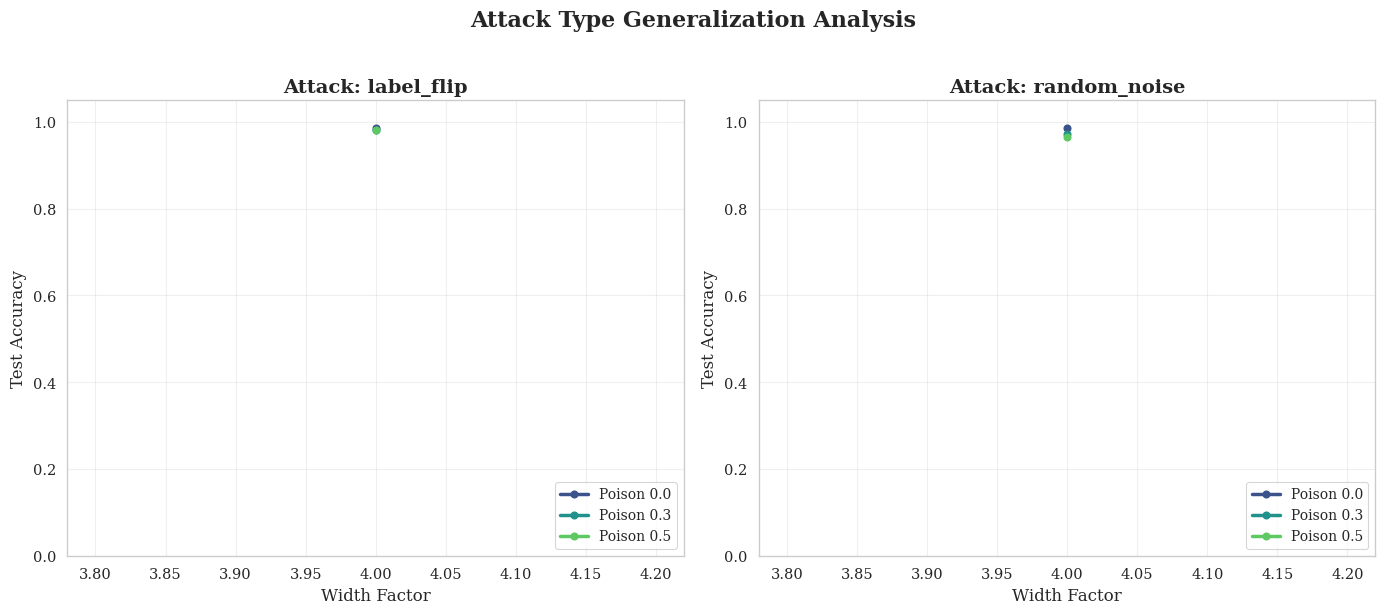

In [7]:
# Create subplots for each attack type
attack_types = df['poison_type'].unique()
fig, axes = plt.subplots(1, len(attack_types), figsize=(7*len(attack_types), 6))

if len(attack_types) == 1:
    axes = [axes]

for idx, attack in enumerate(attack_types):
    subset = df[df['poison_type'] == attack]
    
    # Plot for each poison ratio
    poison_ratios = sorted(subset['poison_ratio'].unique())
    colors = sns.color_palette("viridis", len(poison_ratios))
    
    for i, pr in enumerate(poison_ratios):
        pr_data = subset[subset['poison_ratio'] == pr].sort_values('width_factor')
        axes[idx].plot(pr_data['width_factor'], pr_data['mean_test_acc'],
                       marker='o', linewidth=2.5, color=colors[i],
                       label=f'Poison {pr}')
        axes[idx].fill_between(
            pr_data['width_factor'],
            pr_data['mean_test_acc'] - pr_data['std_test_acc'],
            pr_data['mean_test_acc'] + pr_data['std_test_acc'],
            color=colors[i], alpha=0.2
        )
    
    axes[idx].set_title(f'Attack: {attack}', fontsize=14, weight='bold')
    axes[idx].set_xlabel('Width Factor', fontsize=12)
    axes[idx].set_ylabel('Test Accuracy', fontsize=12)
    axes[idx].legend(loc='lower right', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(0, 1.05)

plt.suptitle('Attack Type Generalization Analysis', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/attack_type_comparison.png")
plt.show()

### 4.2 Attack Effectiveness Comparison

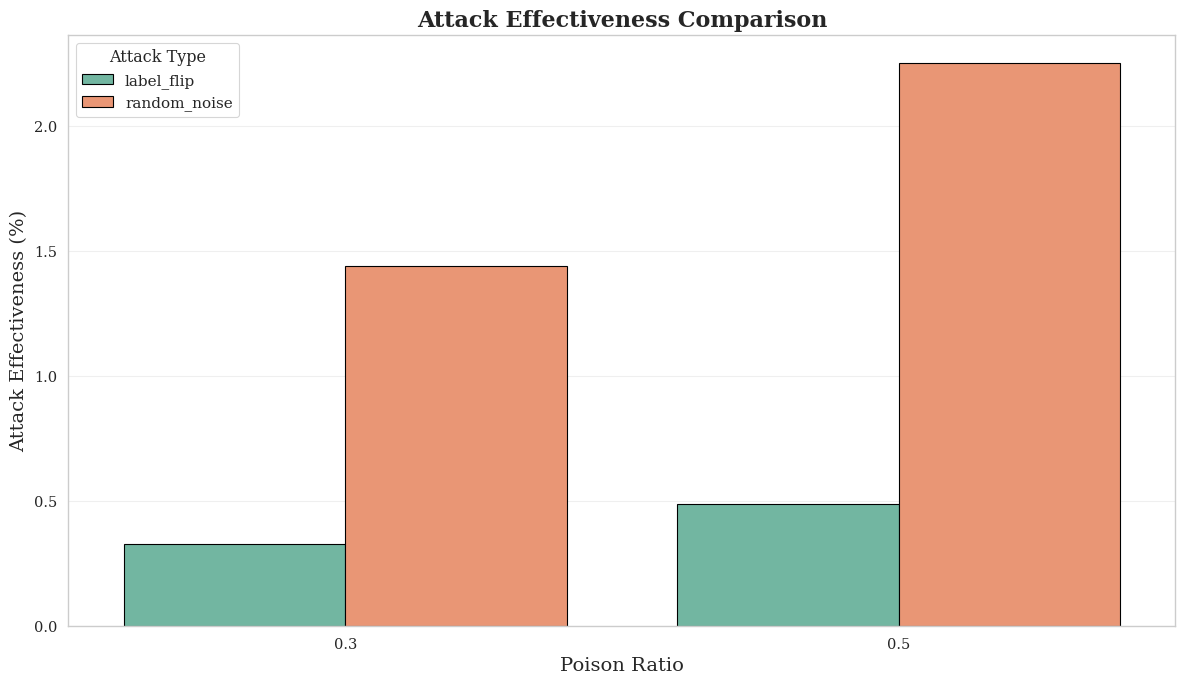

In [8]:
# Calculate attack effectiveness for each type
effectiveness_data = []

for attack in attack_types:
    for width in df['width_factor'].unique():
        for pr in [p for p in df['poison_ratio'].unique() if p > 0]:
            clean_acc = df[(df['poison_type'] == attack) & 
                          (df['width_factor'] == width) & 
                          (df['poison_ratio'] == 0.0)]['mean_test_acc'].values
            poisoned_acc = df[(df['poison_type'] == attack) & 
                             (df['width_factor'] == width) & 
                             (df['poison_ratio'] == pr)]['mean_test_acc'].values
            
            if len(clean_acc) > 0 and len(poisoned_acc) > 0:
                effectiveness = (1 - poisoned_acc[0] / clean_acc[0]) * 100
                effectiveness_data.append({
                    'attack_type': attack,
                    'width_factor': width,
                    'poison_ratio': pr,
                    'effectiveness': effectiveness
                })

eff_df = pd.DataFrame(effectiveness_data)

# Plot
if len(eff_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))
    
    sns.barplot(
        data=eff_df,
        x='poison_ratio',
        y='effectiveness',
        hue='attack_type',
        palette='Set2',
        edgecolor='black',
        ax=ax
    )
    
    ax.set_title('Attack Effectiveness Comparison', fontsize=16, weight='bold')
    ax.set_xlabel('Poison Ratio', fontsize=14)
    ax.set_ylabel('Attack Effectiveness (%)', fontsize=14)
    ax.legend(title='Attack Type', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/attack_effectiveness_comparison.png")
    plt.show()

### 4.3 Cross-Attack Transferability Matrix

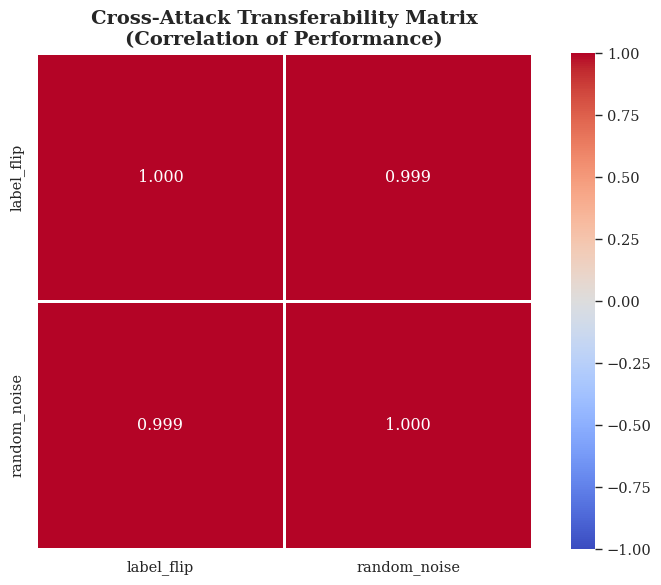


Correlation Interpretation:
  High correlation (>0.7): defenses transfer well between attacks
  Low correlation (<0.3): attacks require different defenses


In [9]:
# Calculate correlation between attack performances
if len(attack_types) > 1:
    # Create pivot for each attack type
    attack_pivots = {}
    for attack in attack_types:
        subset = df[df['poison_type'] == attack]
        # Create unique key for matching
        subset['key'] = (subset['width_factor'].astype(str) + '_' + 
                        subset['poison_ratio'].astype(str))
        attack_pivots[attack] = subset.set_index('key')['mean_test_acc']
    
    # Compute correlation matrix
    corr_df = pd.DataFrame(attack_pivots)
    correlation_matrix = corr_df.corr()
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt='.3f', 
                cmap='coolwarm', center=0, vmin=-1, vmax=1,
                square=True, linewidths=1)
    plt.title('Cross-Attack Transferability Matrix\n(Correlation of Performance)', 
              fontsize=14, weight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/transferability_matrix.png")
    plt.show()
    
    print("\nCorrelation Interpretation:")
    print("  High correlation (>0.7): defenses transfer well between attacks")
    print("  Low correlation (<0.3): attacks require different defenses")

## 5. General Observations

### Key Findings:

1. **Attack Type Comparison**
   - Different attack types may have varying effectiveness
   - Label flipping: targeted, predictable corruption
   - Random noise: untargeted, stochastic corruption

2. **Robustness Generalization**
   - Do wider models resist all attack types equally?
   - Or are some attacks more sensitive to model capacity?

3. **Defense Transferability**
   - High correlation: universal defense (works for all attacks)
   - Low correlation: attack-specific vulnerabilities exist

4. **Hardest Attack**
   - Which attack causes most accuracy degradation?
   - Guides prioritization of defense mechanisms

## 6. Mathematical Analysis

### 6.1 Cross-Attack Generalization Metric

Generalization score $G$ measures correlation between attack vulnerabilities:

$$
G(a_1, a_2) = \text{Corr}\left(\text{Acc}_{a_1}(w, p), \text{Acc}_{a_2}(w, p)\right)
$$

where $a_1, a_2$ are different attack types, $w$ is width, $p$ is poison ratio.

### 6.2 Attack Strength Quantification

In [10]:
# Calculate average attack strength for each type
if len(eff_df) > 0:
    print("Attack Strength Analysis:\n")
    
    for attack in attack_types:
        attack_data = eff_df[eff_df['attack_type'] == attack]
        
        print(f"\n{attack.upper()}:")
        print(f"  Mean Effectiveness: {attack_data['effectiveness'].mean():.2f}%")
        print(f"  Max Effectiveness: {attack_data['effectiveness'].max():.2f}%")
        print(f"  Std Dev: {attack_data['effectiveness'].std():.2f}%")
    
    # Find hardest attack
    attack_strengths = eff_df.groupby('attack_type')['effectiveness'].mean()
    hardest_attack = attack_strengths.idxmax()
    print(f"\nHardest Attack to Defend: {hardest_attack}")
    print(f"  Average Effectiveness: {attack_strengths[hardest_attack]:.2f}%")

Attack Strength Analysis:


LABEL_FLIP:
  Mean Effectiveness: 0.41%
  Max Effectiveness: 0.49%
  Std Dev: 0.11%

RANDOM_NOISE:
  Mean Effectiveness: 1.85%
  Max Effectiveness: 2.25%
  Std Dev: 0.58%

Hardest Attack to Defend: random_noise
  Average Effectiveness: 1.85%


### 6.3 Statistical Comparison Between Attack Types

In [11]:
# Compare attack types statistically
if len(attack_types) > 1:
    print("\nPairwise Statistical Comparison:\n")
    
    for pr in [p for p in df['poison_ratio'].unique() if p > 0]:
        print(f"\n{'='*60}")
        print(f"Poison Ratio: {pr}")
        print(f"{'='*60}")
        
        attack_list = list(attack_types)
        for i in range(len(attack_list)):
            for j in range(i+1, len(attack_list)):
                attack1 = attack_list[i]
                attack2 = attack_list[j]
                
                data1 = df[(df['poison_type'] == attack1) & 
                          (df['poison_ratio'] == pr)]['mean_test_acc'].values
                data2 = df[(df['poison_type'] == attack2) & 
                          (df['poison_ratio'] == pr)]['mean_test_acc'].values
                
                if len(data1) > 0 and len(data2) > 0:
                    t_stat, p_value = stats.ttest_ind(data1, data2)
                    
                    print(f"\n{attack1} vs {attack2}:")
                    print(f"  {attack1}: {data1.mean():.4f} ± {data1.std():.4f}")
                    print(f"  {attack2}: {data2.mean():.4f} ± {data2.std():.4f}")
                    print(f"  t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
                    
                    if p_value < 0.05:
                        winner = attack1 if data1.mean() > data2.mean() else attack2
                        print(f"  ✓ {winner} shows better robustness (p < 0.05)")
                    else:
                        print("  ✗ No significant difference (p >= 0.05)")


Pairwise Statistical Comparison:


Poison Ratio: 0.3

label_flip vs random_noise:
  label_flip: 0.9822 ± 0.0000
  random_noise: 0.9726 ± 0.0000
  t-statistic: nan, p-value: nan
  ✗ No significant difference (p >= 0.05)

Poison Ratio: 0.5

label_flip vs random_noise:
  label_flip: 0.9807 ± 0.0000
  random_noise: 0.9645 ± 0.0000
  t-statistic: nan, p-value: nan
  ✗ No significant difference (p >= 0.05)


## 7. Conclusions

### Key Takeaways:

1. **Generalization of Width-Based Defense**
   - Confirms whether robustness from wider models applies across attack types
   - Universal defense vs attack-specific vulnerabilities

2. **Attack Transferability**
   - High correlation: defense mechanisms generalize well
   - Low correlation: need diverse defense portfolio

3. **Most Challenging Attack**
   - Identifies which attack type is hardest to defend against
   - Prioritizes research and defense development

4. **Practical Deployment Insights**
   - If defenses generalize: single defense strategy sufficient
   - If attack-specific: need adaptive/ensemble defenses

5. **Research Implications**
   - validates robustness findings across multiple threat models
   - Broader applicability of architectural defenses
   - Future: test on more sophisticated attacks (backdoors, gradient-based)

### Final Summary

This experiment completes the comprehensive analysis by verifying that findings generalize beyond a single attack type. The transferability analysis reveals whether we've discovered universal robustness principles or attack-specific phenomena.

---

**Complete Analysis Overview**: 
- **Exp0**: Width vs Depth trade-offs
- **Exp1**: Double descent and over-parameterization benefits
- **Exp2**: Intrinsic (width) vs Extrinsic (aggregation) defenses
- **Exp3**: Mechanism analysis (batch size, ordering)
- **Exp4**: Attack type generalization (current)

**See CIFAR10 notebooks for validation on more complex datasets.**